<h1>Kidney Disease Classification Using Deep Learning and CT Scan Images</h1>

Detecting kidney conditions early is critical as they often progress without noticeable symptoms 
until they reach advanced stages. Early diagnosis can prevent kidney failure, improve patient
outcomes, and reduce healthcare costs. Techniques like medical imaging and AI-powered diagnostics
are revolutionizing how kidney conditions are identified and treated.

<h3>EDA OF THE DATASET</h3>

Classes in the dataset: ['Normal', 'Cyst', 'Tumor', 'Stone']

Number of images per class:
Class
Normal    5077
Cyst      3709
Tumor     2283
Stone     1377
Name: count, dtype: int64


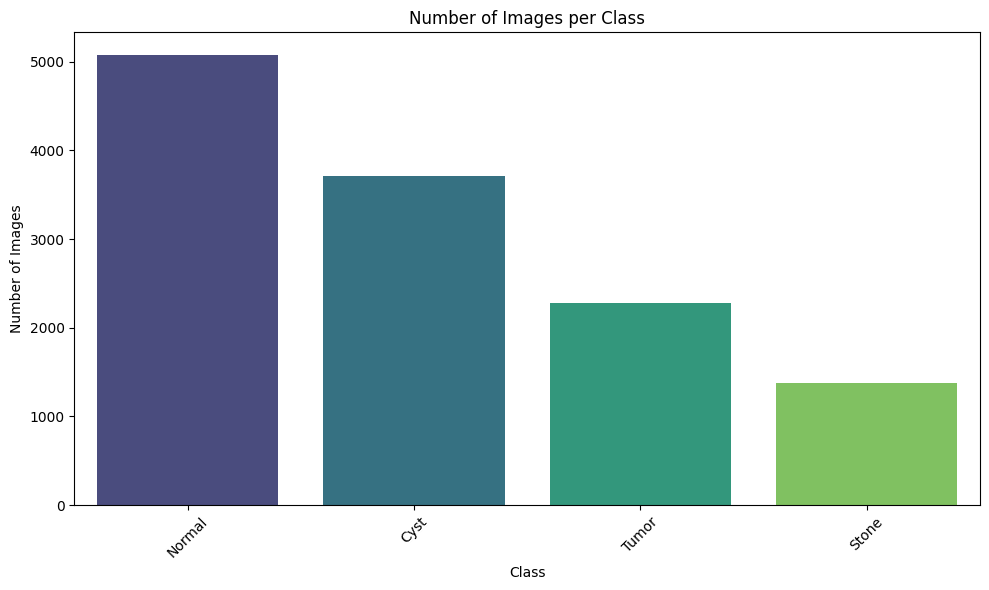

In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Load the dataset
file_path = '/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/kidneyData.csv'
data = pd.read_csv(file_path)

class_counts = data['Class'].value_counts()
classes = class_counts.index.tolist()
print("Classes in the dataset:", classes)
print("\nNumber of images per class:")
print(class_counts)

# Visualize Image Counts
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.title("Number of Images per Class")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<b><h5>Some Sample images of all 4 classes</h5></b>

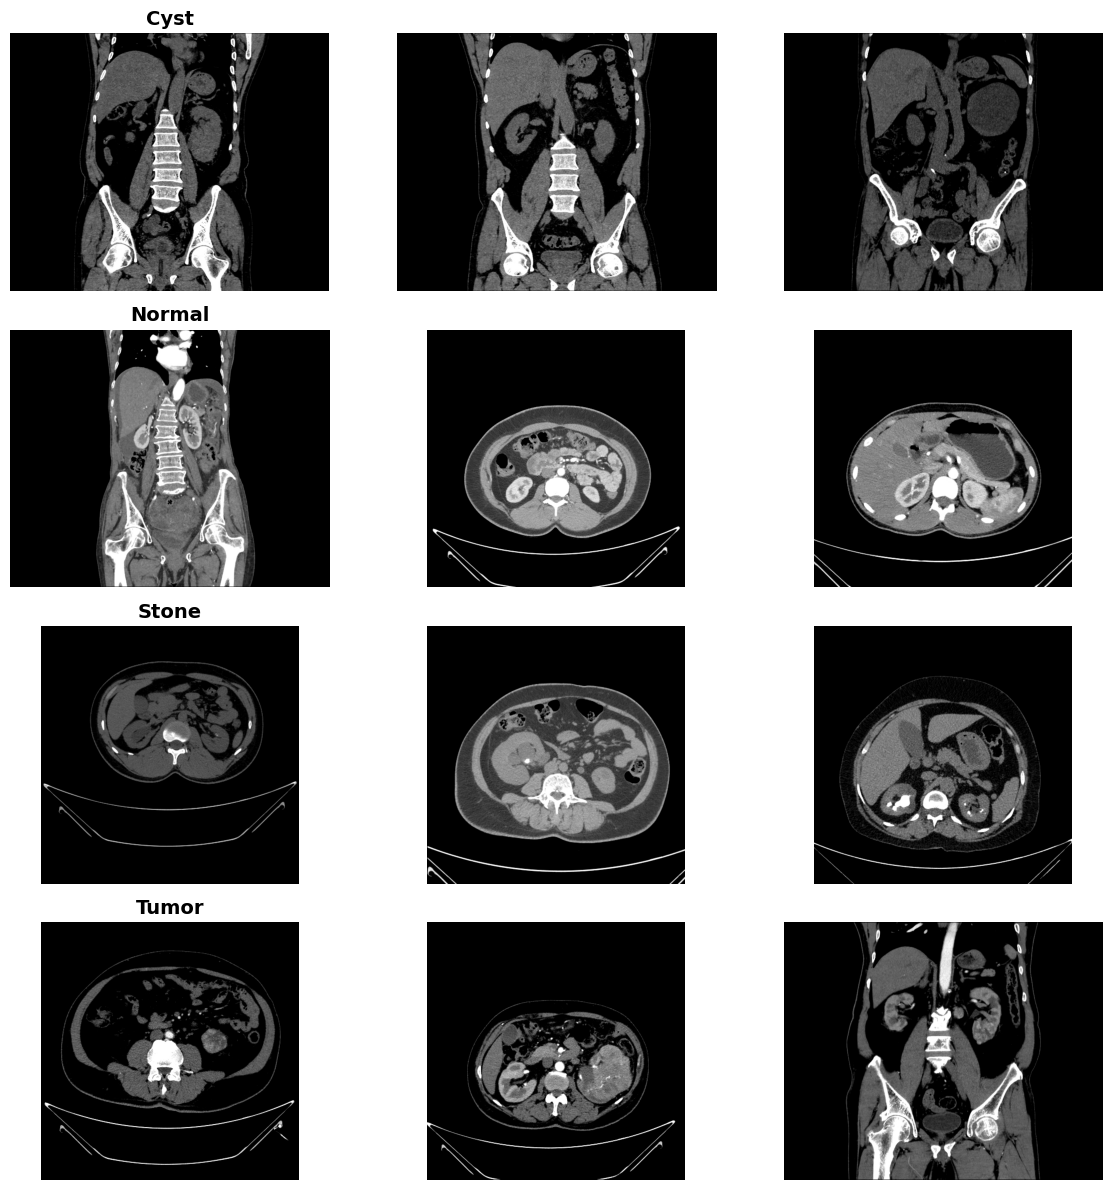

In [28]:
# Dataset directory
dataset_dir = '/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'

# Class names
class_names = ['Cyst', 'Normal', 'Stone', 'Tumor']

fig, axes = plt.subplots(4, 3, figsize=(12, 12))

# Loop through the classes and display 3 images for each class
for i, class_name in enumerate(class_names):
    class_dir = os.path.join(dataset_dir, class_name)
    images = os.listdir(class_dir)[:3] 
    
    
    axes[i, 0].set_title(class_name, fontsize=14, fontweight='bold')

    for j, image_name in enumerate(images):
        image_path = os.path.join(class_dir, image_name)
        img = Image.open(image_path)
        
        # Display the image in the appropriate subplot
        ax = axes[i, j]
        ax.imshow(img)
        ax.axis('off')  
        
        if j == 0:
            ax.set_title(class_name, fontsize=14, fontweight='bold')
    
plt.tight_layout()
plt.show()


<H2>MODEL TRAINING</H2>

<h3>Import Libraries</h3>

In [2]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from PIL import Image

<h3>Load Dataset</h3>

In [3]:
# Load metadata
metadata = pd.read_csv('/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/kidneyData.csv')

# Define dataset paths
data_dir = "/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"  


<h3>Define Class Distribution and Handlingling Class weights</h3>

In [10]:
class_names = ["Cyst", "Normal", "Stone", "Tumor"]
class_counts = {"Cyst": 3709, "Normal": 5077, "Stone": 1377, "Tumor": 2283}

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Handling imbalance with class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array(range(len(class_names))),
    y=np.repeat(range(len(class_names)), [class_counts[c] for c in class_names])
)
class_weights = torch.tensor(class_weights, dtype=torch.float32)
class_weights = class_weights.to(device)


cuda


<h3>Define Custom Dataset Class</h3>

In [11]:
class KidneyDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        image = Image.open(self.file_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

<h3>Prepare Dataset for Training and Testing</h3>

In [13]:
file_paths, labels = [], []
for label, class_name in enumerate(class_names):
    class_dir = os.path.join(data_dir, class_name)
    for file_name in os.listdir(class_dir):
        file_paths.append(os.path.join(class_dir, file_name))
        labels.append(label)

file_paths = np.array(file_paths)
labels = np.array(labels)

#Splitting Dataset with 70-train 15-test and 15-val
train_paths, temp_paths, train_labels, temp_labels = train_test_split(file_paths, labels, test_size=0.3, stratify=labels, random_state=42)
val_paths, test_paths, val_labels, test_labels = train_test_split(temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)


<h3>Define Data Transforms and Loaders</h3>

In [14]:
# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Data loaders
train_dataset = KidneyDataset(train_paths, train_labels, transform=transform)
val_dataset = KidneyDataset(val_paths, val_labels, transform=transform)
test_dataset = KidneyDataset(test_paths, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


<h3>Build and Configure the Model</h3>

In [18]:
# Build the model
model = models.efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(class_names))

# Define loss and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


<h3>Define and Train the Model with Early Stopping</h3>

In [22]:
def train_model(model, train_loader, val_loader, num_epochs=15, patience=2):
    best_val_acc = 0
    best_epoch = 0
    patience_counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()

        train_loss /= len(train_loader.dataset)
        train_acc = train_correct / len(train_loader.dataset)

        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch + 1
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    print(f"Best Validation Accuracy: {best_val_acc:.4f} at Epoch {best_epoch}")
    return best_val_acc, best_epoch

# Train the model
best_val_acc, best_epoch = train_model(model, train_loader, val_loader)


Epoch 1/15, Train Loss: 0.0148, Train Acc: 0.9953, Val Loss: 0.0048, Val Acc: 0.9979
Epoch 2/15, Train Loss: 0.0253, Train Acc: 0.9946, Val Loss: 0.0110, Val Acc: 0.9936
Epoch 3/15, Train Loss: 0.0112, Train Acc: 0.9966, Val Loss: 0.0092, Val Acc: 0.9989
Epoch 4/15, Train Loss: 0.0035, Train Acc: 0.9987, Val Loss: 0.0049, Val Acc: 0.9984
Epoch 5/15, Train Loss: 0.0049, Train Acc: 0.9989, Val Loss: 0.0073, Val Acc: 0.9968
Early stopping triggered.
Best Validation Accuracy: 0.9989 at Epoch 3


<h3>Evaluation with Confusion Matrix ,ROC Curve and Classification Report</h3>

/tmp/ipykernel_23/2698000670.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


Test Accuracy: 0.9989


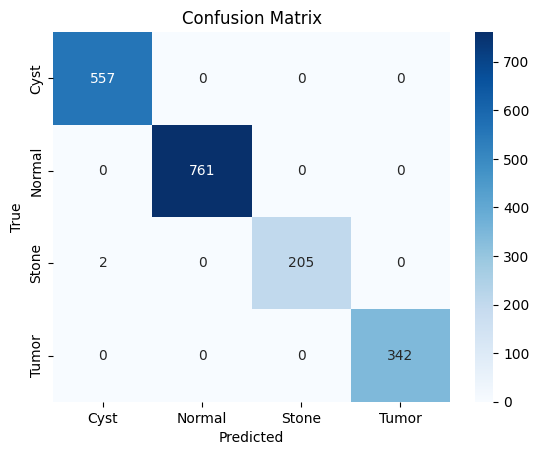

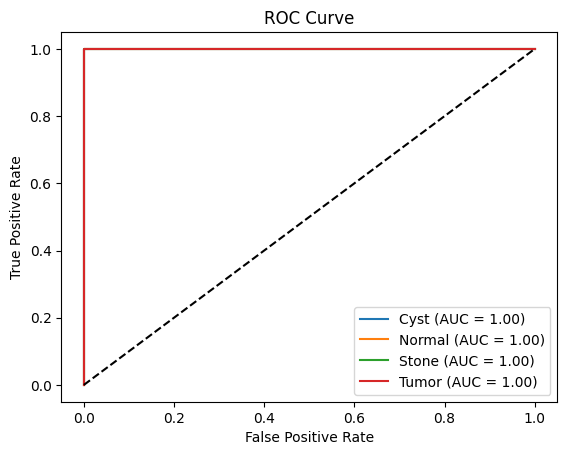

              precision    recall  f1-score   support

        Cyst       1.00      1.00      1.00       557
      Normal       1.00      1.00      1.00       761
       Stone       1.00      0.99      1.00       207
       Tumor       1.00      1.00      1.00       342

    accuracy                           1.00      1867
   macro avg       1.00      1.00      1.00      1867
weighted avg       1.00      1.00      1.00      1867



In [23]:
from sklearn.metrics import classification_report

# Load the best model and set it to evaluation mode
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Variables to store results
test_correct = 0
all_preds, all_labels = [], []

# Iterate through the test set
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        test_correct += (preds == labels).sum().item()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate and print test accuracy
test_acc = test_correct / len(test_loader.dataset)
print(f"Test Accuracy: {test_acc:.4f}")

# ## Confusion Matrix

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix as heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ## ROC Curve

# Calculate probabilities for ROC curve
all_probs = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        probs = torch.softmax(model(images), dim=1).cpu().numpy()
        all_probs.extend(probs)

# Convert probabilities to numpy array
all_probs = np.array(all_probs)

# Plot ROC curve for each class
plt.figure()
for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve((np.array(all_labels) == i).astype(int), all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# ## Classification Report

# Generate and print the classification report
report = classification_report(all_labels, all_preds, target_names=class_names)
print(report)


<h3>Save the Model</h3>

In [24]:
torch.save(model, "kidney_model.pth")